# E-Commerce Customer Churn Prediction – Datathon Project
**Goal:** Build a machine learning solution to predict customer churn, identify at-risk segments, and recommend retention strategies to minimize revenue loss.

## Section 1: Load and Explore Data
Import required libraries and load the e-commerce transactions dataset for initial exploration.

In [3]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (auc, roc_curve, confusion_matrix,
                             classification_report, roc_auc_score,
                             precision_score, recall_score, f1_score, accuracy_score)
from sklearn.cluster import KMeans
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [4]:
# Load Data
df = pd.read_csv('ecommerce_transactions.csv')

print("Dataset loaded successfully!")
print(f"\nDataset Shape: {df.shape}")
print(f"Total Transactions: {len(df):,}")
print(f"Unique Customers: {df['User_Name'].nunique():,}")
print("\n" + "="*60)
print("Data Overview:")
print("="*60)
print(df.head(10))
print("\n" + "="*60)
print("Data Types:")
print("="*60)
print(df.dtypes)
print("\n" + "="*60)
print("Missing Values:")
print("="*60)
print(df.isnull().sum())
print("\n" + "="*60)
print("Basic Statistics:")
print("="*60)
print(df.describe())

Dataset loaded successfully!

Dataset Shape: (50000, 8)
Total Transactions: 50,000
Unique Customers: 100

Data Overview:
   Transaction_ID        User_Name  Age  Country Product_Category  \
0               1         Ava Hall   63   Mexico         Clothing   
1               2      Sophia Hall   59    India           Beauty   
2               3  Elijah Thompson   26   France            Books   
3               4     Elijah White   43   Mexico           Sports   
4               5       Ava Harris   48  Germany           Beauty   
5               6    Elijah Harris   51    India             Toys   
6               7     Oliver Clark   27  Germany   Home & Kitchen   
7               8     Olivia Allen   46   Canada   Home & Kitchen   
8               9      Liam Harris   54   France           Beauty   
9              10       Liam Allen   60   Canada           Beauty   

   Purchase_Amount    Payment_Method Transaction_Date  
0           780.69        Debit Card       2023-04-14  
1      

## Section 2: Data Cleaning and Preprocessing
Check for data quality issues, handle missing values, and convert date columns to appropriate format.

In [5]:
# Data Cleaning
print("Data Cleaning:")
print("="*60)

# Convert Transaction_Date to datetime
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum()}")

# Identify outliers in Purchase_Amount
print(f"\nPurchase_Amount Statistics:")
print(f"  Min: ${df['Purchase_Amount'].min():.2f}")
print(f"  Max: ${df['Purchase_Amount'].max():.2f}")
print(f"  Mean: ${df['Purchase_Amount'].mean():.2f}")
print(f"  Median: ${df['Purchase_Amount'].median():.2f}")
print(f"  Std Dev: ${df['Purchase_Amount'].std():.2f}")

# Check for negative amounts
negative_amounts = (df['Purchase_Amount'] < 0).sum()
print(f"  Negative amounts: {negative_amounts}")

# Date range
print(f"\nTransaction Date Range:")
print(f"  Earliest: {df['Transaction_Date'].min()}")
print(f"  Latest: {df['Transaction_Date'].max()}")
print(f"  Span: {(df['Transaction_Date'].max() - df['Transaction_Date'].min()).days} days")

# Define T_end (last date in dataset)
T_end = df['Transaction_Date'].max()
print(f"\nT_end (Analysis Date): {T_end}")

print("\n✓ Data cleaning completed!")

Data Cleaning:
Duplicate rows: 0

Missing values:
Transaction_ID      0
User_Name           0
Age                 0
Country             0
Product_Category    0
Purchase_Amount     0
Payment_Method      0
Transaction_Date    0
dtype: int64

Purchase_Amount Statistics:
  Min: $5.04
  Max: $999.98
  Mean: $503.16
  Median: $503.11
  Std Dev: $286.56
  Negative amounts: 0

Transaction Date Range:
  Earliest: 2023-03-09 00:00:00
  Latest: 2025-03-08 00:00:00
  Span: 730 days

T_end (Analysis Date): 2025-03-08 00:00:00

✓ Data cleaning completed!


## Section 3: Feature Engineering - RFM and Behavioral Features
Aggregate transaction data to customer-level and calculate RFM (Recency, Frequency, Monetary) and behavioral features.

In [6]:
# Aggregate to Customer Level
print("Aggregating data to customer level...")

# Create customer-level features
customer_data = df.groupby('User_Name').agg({
    'Transaction_ID': 'count',  # frequency (total orders)
    'Purchase_Amount': ['sum', 'mean', 'max', 'std'],
    'Transaction_Date': ['min', 'max'],
    'Product_Category': 'nunique',
    'Country': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    'Age': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    'Payment_Method': 'nunique'
}).reset_index()

# Flatten column names
customer_data.columns = ['User_Name', 'total_orders', 'total_revenue', 'avg_order_value',
                         'max_order_value', 'std_order_value', 'first_purchase_date',
                         'last_purchase_date', 'distinct_categories', 'country',
                         'age', 'payment_methods_used']

print(f"\nCustomer-level data created: {len(customer_data)} unique customers")

# RFM Features
# Recency: days since last purchase
customer_data['recency_days'] = (T_end - customer_data['last_purchase_date']).dt.days

# Frequency: already have total_orders
# Calculate orders in last 30, 60, 90 days
customer_data['orders_last_30'] = df.groupby('User_Name').apply(
    lambda x: ((T_end - x['Transaction_Date']).dt.days <= 30).sum()
).reset_index(drop=True)

customer_data['orders_last_60'] = df.groupby('User_Name').apply(
    lambda x: ((T_end - x['Transaction_Date']).dt.days <= 60).sum()
).reset_index(drop=True)

customer_data['orders_last_90'] = df.groupby('User_Name').apply(
    lambda x: ((T_end - x['Transaction_Date']).dt.days <= 90).sum()
).reset_index(drop=True)

# Tenure: days since first purchase
customer_data['tenure_days'] = (T_end - customer_data['first_purchase_date']).dt.days

# Fill NaN in std_order_value with 0
customer_data['std_order_value'] = customer_data['std_order_value'].fillna(0)

# Drop date columns
customer_data = customer_data.drop(['first_purchase_date', 'last_purchase_date'], axis=1)

print("\n" + "="*60)
print("Customer-level Features Created:")
print("="*60)
print(f"Shape: {customer_data.shape}")
print(f"\nFirst 5 customers:\n{customer_data.head()}")
print(f"\nFeature statistics:\n{customer_data.describe()}")

print("\n✓ Feature engineering completed!")

Aggregating data to customer level...

Customer-level data created: 100 unique customers

Customer-level Features Created:
Shape: (100, 15)

First 5 customers:
      User_Name  total_orders  total_revenue  avg_order_value  \
0     Ava Allen           494      247865.13       501.751275   
1  Ava Anderson           491      246801.09       502.649878   
2     Ava Clark           517      273776.79       529.548917   
3      Ava Hall           517      268756.73       519.838936   
4    Ava Harris           520      266846.08       513.165538   

   max_order_value  std_order_value  distinct_categories country  age  \
0           994.53       281.484079                    8     USA   39   
1           998.19       295.112046                    8  Canada   36   
2           998.67       288.494191                    8   Japan   39   
3           999.89       288.930949                    8     USA   22   
4           999.50       295.715299                    8  Brazil   55   

   payment

## Section 4: Churn Target Definition
Define churn based on inactivity threshold and create binary target variable.

In [7]:
# Define Churn Target Variable
# Churn threshold: 60 days of inactivity
CHURN_THRESHOLD = 60

customer_data['churn'] = (customer_data['recency_days'] > CHURN_THRESHOLD).astype(int)

print("Churn Definition:")
print("="*60)
print(f"Churn Threshold: {CHURN_THRESHOLD} days (no purchase)")
print(f"\nChurn Distribution:")
print(customer_data['churn'].value_counts())
print(f"\nChurn Rate: {customer_data['churn'].mean()*100:.2f}%")

# Class imbalance analysis
churn_counts = customer_data['churn'].value_counts()
print(f"\nClass Imbalance Ratio:")
print(f"  Active customers (churn=0): {churn_counts[0]:,} ({churn_counts[0]/len(customer_data)*100:.1f}%)")
print(f"  Churned customers (churn=1): {churn_counts[1]:,} ({churn_counts[1]/len(customer_data)*100:.1f}%)")
print(f"  Imbalance ratio: {churn_counts[0]/churn_counts[1]:.2f}:1")

# Visualize churn distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
customer_data['churn'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Churn Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Churn Status')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Active (0)', 'Churned (1)'], rotation=0)

# Pie chart
customer_data['churn'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                           colors=['#2ecc71', '#e74c3c'])
axes[1].set_title('Churn Proportion', fontsize=12, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print("\n✓ Churn target defined!")

Churn Definition:
Churn Threshold: 60 days (no purchase)

Churn Distribution:
churn
0    100
Name: count, dtype: int64

Churn Rate: 0.00%

Class Imbalance Ratio:
  Active customers (churn=0): 100 (100.0%)


KeyError: 1

## Section 5: Exploratory Data Analysis (EDA)
Visualize distributions of key features and analyze relationships with churn target.

Exploratory Data Analysis:

Key Metrics by Churn Status:
       recency_days  total_orders  total_revenue  avg_order_value  tenure_days
churn                                                                         
0              1.11         500.0    251579.8965       503.070623       728.98


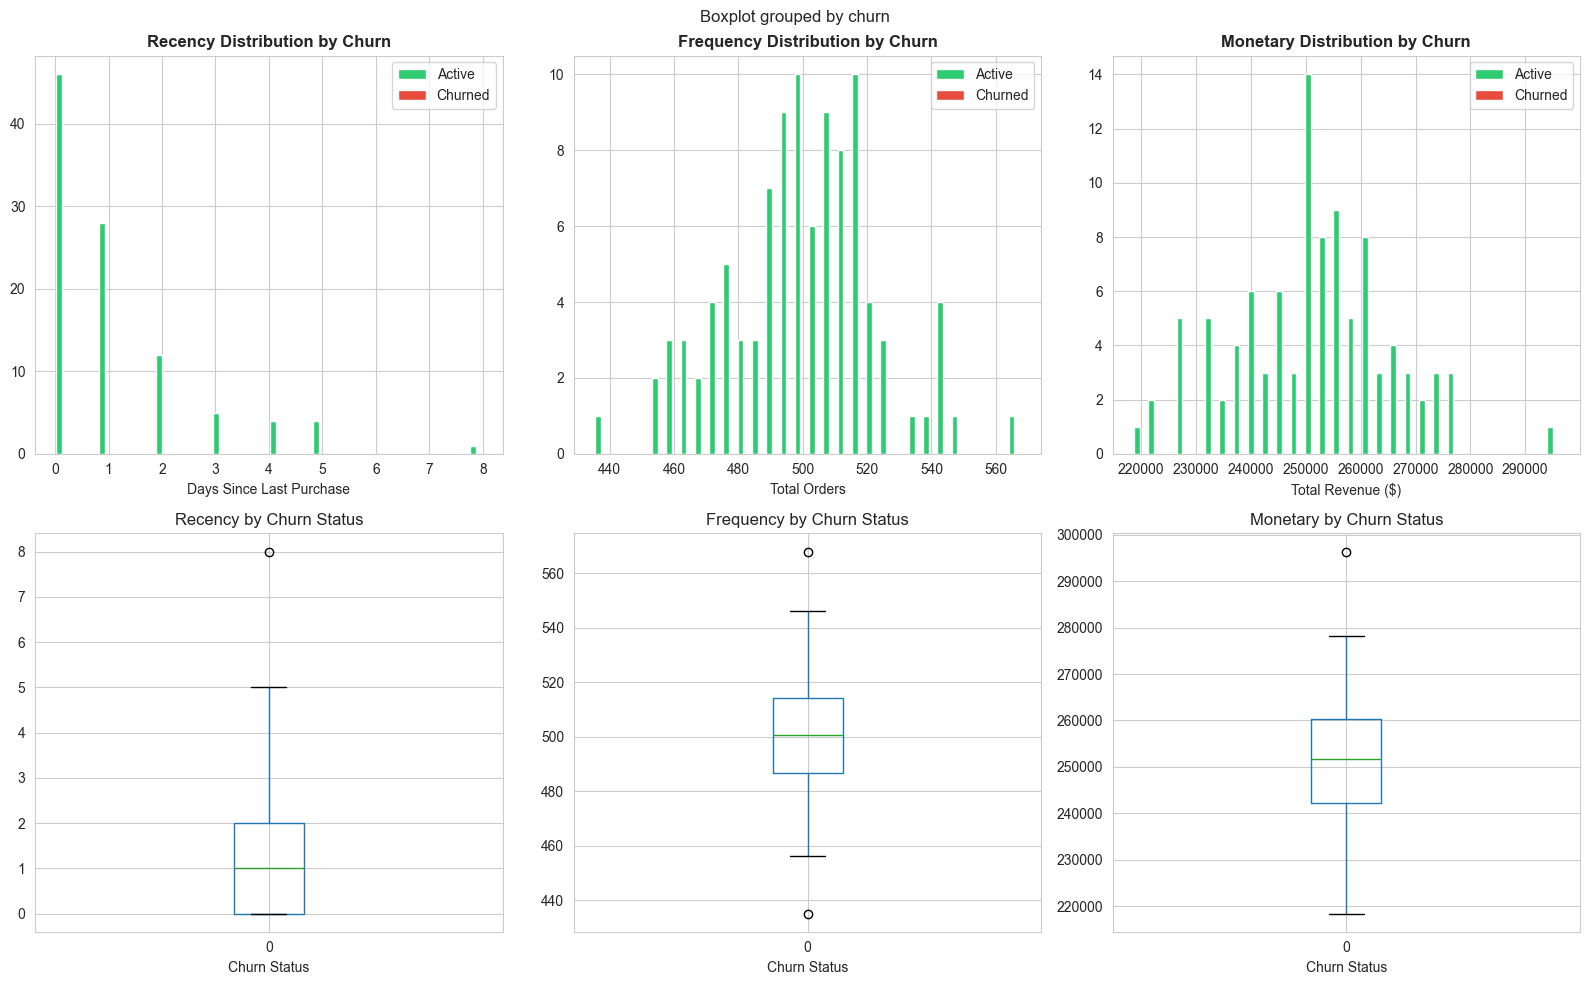


✓ EDA completed!


In [8]:
# EDA - Key Features vs Churn
print("Exploratory Data Analysis:")
print("="*60)

# Key statistics by churn status
print("\nKey Metrics by Churn Status:")
print(customer_data.groupby('churn')[['recency_days', 'total_orders', 'total_revenue',
                                       'avg_order_value', 'tenure_days']].mean())

# Visualize RFM by Churn Status
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Recency
axes[0, 0].hist([customer_data[customer_data['churn']==0]['recency_days'],
                 customer_data[customer_data['churn']==1]['recency_days']],
                label=['Active', 'Churned'], bins=30, color=['#2ecc71', '#e74c3c'])
axes[0, 0].set_title('Recency Distribution by Churn', fontweight='bold')
axes[0, 0].set_xlabel('Days Since Last Purchase')
axes[0, 0].legend()

# Frequency
axes[0, 1].hist([customer_data[customer_data['churn']==0]['total_orders'],
                 customer_data[customer_data['churn']==1]['total_orders']],
                label=['Active', 'Churned'], bins=30, color=['#2ecc71', '#e74c3c'])
axes[0, 1].set_title('Frequency Distribution by Churn', fontweight='bold')
axes[0, 1].set_xlabel('Total Orders')
axes[0, 1].legend()

# Monetary
axes[0, 2].hist([customer_data[customer_data['churn']==0]['total_revenue'],
                 customer_data[customer_data['churn']==1]['total_revenue']],
                label=['Active', 'Churned'], bins=30, color=['#2ecc71', '#e74c3c'])
axes[0, 2].set_title('Monetary Distribution by Churn', fontweight='bold')
axes[0, 2].set_xlabel('Total Revenue ($)')
axes[0, 2].legend()

# Box plots
customer_data.boxplot(column='recency_days', by='churn', ax=axes[1, 0])
axes[1, 0].set_title('Recency by Churn Status')
axes[1, 0].set_xlabel('Churn Status')

customer_data.boxplot(column='total_orders', by='churn', ax=axes[1, 1])
axes[1, 1].set_title('Frequency by Churn Status')
axes[1, 1].set_xlabel('Churn Status')

customer_data.boxplot(column='total_revenue', by='churn', ax=axes[1, 2])
axes[1, 2].set_title('Monetary by Churn Status')
axes[1, 2].set_xlabel('Churn Status')

plt.tight_layout()
plt.show()

print("\n✓ EDA completed!")

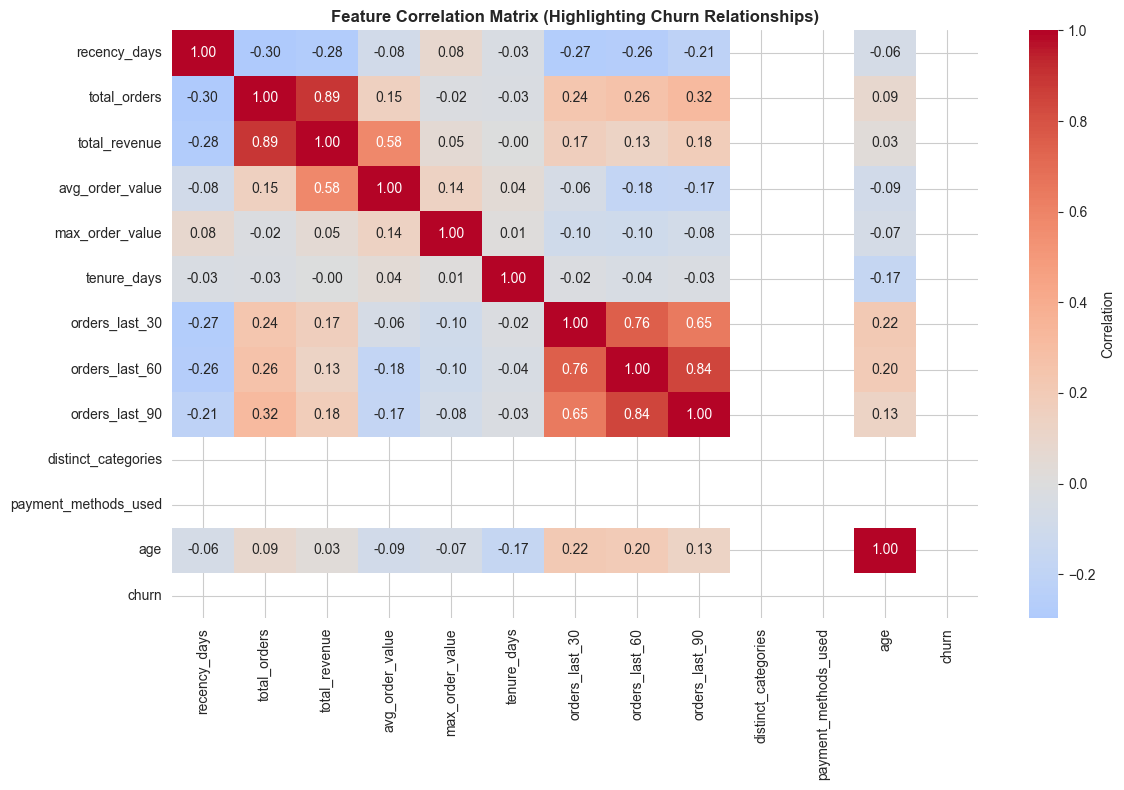

Top features correlated with churn:
recency_days           NaN
total_orders           NaN
total_revenue          NaN
avg_order_value        NaN
max_order_value        NaN
tenure_days            NaN
orders_last_30         NaN
orders_last_60         NaN
orders_last_90         NaN
distinct_categories    NaN
payment_methods_used   NaN
age                    NaN
churn                  NaN
Name: churn, dtype: float64


In [9]:
# Correlation Analysis
fig, ax = plt.subplots(figsize=(12, 8))

# Select numerical features for correlation
numerical_features = ['recency_days', 'total_orders', 'total_revenue', 'avg_order_value',
                      'max_order_value', 'tenure_days', 'orders_last_30', 'orders_last_60',
                      'orders_last_90', 'distinct_categories', 'payment_methods_used', 'age', 'churn']

corr_matrix = customer_data[numerical_features].corr()

# Heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax,
            cbar_kws={'label': 'Correlation'})
ax.set_title('Feature Correlation Matrix (Highlighting Churn Relationships)', fontweight='bold')
plt.tight_layout()
plt.show()

print("Top features correlated with churn:")
print(corr_matrix['churn'].sort_values(ascending=False))

## Section 6: Feature Scaling and Train-Test Split
Normalize numerical features, encode categorical variables, and prepare data for modeling.

In [10]:
# Feature Scaling and Encoding
print("Feature Scaling and Train-Test Split:")
print("="*60)

# Prepare data for modeling
X = customer_data.drop(['User_Name', 'churn', 'country'], axis=1)
y = customer_data['churn']

# Encode categorical variables if needed (country can be used but we'll exclude it for now)
# X = pd.get_dummies(X, columns=['country'], drop_first=True)

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split into train and test sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)

print(f"\nTrain set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"\nTrain set churn distribution:")
print(y_train.value_counts())
print(f"\nTest set churn distribution:")
print(y_test.value_counts())

# Standardize features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier tracking
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print(f"\n✓ Features scaled (mean=0, std=1)")
print(f"  Train set sample statistics:\n{X_train_scaled.describe().loc[['mean', 'std']].head()}")

print("\n✓ Data preparation completed!")

Feature Scaling and Train-Test Split:

Features shape: (100, 13)
Target shape: (100,)

Train set size: 70 samples
Test set size: 30 samples

Train set churn distribution:
churn
0    70
Name: count, dtype: int64

Test set churn distribution:
churn
0    30
Name: count, dtype: int64

✓ Features scaled (mean=0, std=1)
  Train set sample statistics:
      total_orders  total_revenue  avg_order_value  max_order_value  \
mean  7.073707e-16   2.668699e-15     2.022192e-15     3.367148e-15   
std   1.007220e+00   1.007220e+00     1.007220e+00     1.007220e+00   

      std_order_value  distinct_categories           age  \
mean    -7.841347e-15                  0.0 -1.998401e-16   
std      1.007220e+00                  0.0  1.007220e+00   

      payment_methods_used  recency_days  orders_last_30  orders_last_60  \
mean                   0.0 -5.015829e-17    1.595946e-16   -1.268826e-16   
std                    0.0  1.007220e+00    1.007220e+00    1.007220e+00   

      orders_last_90   tenure

## Section 7: Baseline Model - Logistic Regression
Train a Logistic Regression model as the baseline and evaluate its performance.

In [11]:
# Train Logistic Regression Baseline Model
print("Training Logistic Regression Baseline Model:")
print("="*60)

# Calculate class weights to handle imbalance
class_weight_dict = {0: 1, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])}
print(f"Class weights: {class_weight_dict}")

# Train model
lr_model = LogisticRegression(max_iter=1000, class_weight=class_weight_dict, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)
y_test_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\nLogistic Regression - Training Set Performance:")
print(f"  Accuracy: {accuracy_score(y_train, y_train_pred_lr):.4f}")
print(f"  AUC-ROC: {roc_auc_score(y_train, lr_model.predict_proba(X_train_scaled)[:, 1]):.4f}")

print("\nLogistic Regression - Test Set Performance:")
print(f"  Accuracy: {accuracy_score(y_test, y_test_pred_lr):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred_lr):.4f}")
print(f"  Recall: {recall_score(y_test, y_test_pred_lr):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_test_pred_lr):.4f}")
print(f"  AUC-ROC: {roc_auc_score(y_test, y_test_pred_proba_lr):.4f}")

print("\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, y_test_pred_lr)
print(cm_lr)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_lr, target_names=['Active', 'Churned']))

# Feature importance (coefficients)
feature_importance_lr = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 10 Features (by coefficient magnitude):")
print(feature_importance_lr.head(10))

print("\n✓ Logistic Regression model trained!")

Training Logistic Regression Baseline Model:


ZeroDivisionError: division by zero

## Section 8: Advanced Models - Random Forest and XGBoost
Train tree-based models and compare against the baseline.

In [12]:
# Train Random Forest Model
print("Training Random Forest Model:")
print("="*60)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=15,
                                  class_weight='balanced', random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)
y_test_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("\nRandom Forest - Training Set Performance:")
print(f"  Accuracy: {accuracy_score(y_train, y_train_pred_rf):.4f}")
print(f"  AUC-ROC: {roc_auc_score(y_train, rf_model.predict_proba(X_train_scaled)[:, 1]):.4f}")

print("\nRandom Forest - Test Set Performance:")
print(f"  Accuracy: {accuracy_score(y_test, y_test_pred_rf):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred_rf):.4f}")
print(f"  Recall: {recall_score(y_test, y_test_pred_rf):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_test_pred_rf):.4f}")
print(f"  AUC-ROC: {roc_auc_score(y_test, y_test_pred_proba_rf):.4f}")

print("\n✓ Random Forest model trained!")

Training Random Forest Model:


IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
# Train XGBoost Model
print("\nTraining XGBoost Model:")
print("="*60)

# Calculate scale_pos_weight for XGBoost class imbalance handling
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1,
                              scale_pos_weight=scale_pos_weight, random_state=42,
                              eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_test_pred_xgb = xgb_model.predict(X_test_scaled)
y_test_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

print("\nXGBoost - Training Set Performance:")
print(f"  Accuracy: {accuracy_score(y_train, y_train_pred_xgb):.4f}")
print(f"  AUC-ROC: {roc_auc_score(y_train, xgb_model.predict_proba(X_train_scaled)[:, 1]):.4f}")

print("\nXGBoost - Test Set Performance:")
print(f"  Accuracy: {accuracy_score(y_test, y_test_pred_xgb):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred_xgb):.4f}")
print(f"  Recall: {recall_score(y_test, y_test_pred_xgb):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_test_pred_xgb):.4f}")
print(f"  AUC-ROC: {roc_auc_score(y_test, y_test_pred_proba_xgb):.4f}")

print("\n✓ XGBoost model trained!")

## Section 9: Model Evaluation and Comparison
Compare all three models side-by-side with comprehensive evaluation metrics.

In [ ]:
# Model Comparison
print("Model Performance Comparison:")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_test_pred_lr),
        accuracy_score(y_test, y_test_pred_rf),
        accuracy_score(y_test, y_test_pred_xgb)
    ],
    'Precision': [
        precision_score(y_test, y_test_pred_lr),
        precision_score(y_test, y_test_pred_rf),
        precision_score(y_test, y_test_pred_xgb)
    ],
    'Recall': [
        recall_score(y_test, y_test_pred_lr),
        recall_score(y_test, y_test_pred_rf),
        recall_score(y_test, y_test_pred_xgb)
    ],
    'F1-Score': [
        f1_score(y_test, y_test_pred_lr),
        f1_score(y_test, y_test_pred_rf),
        f1_score(y_test, y_test_pred_xgb)
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, y_test_pred_proba_lr),
        roc_auc_score(y_test, y_test_pred_proba_rf),
        roc_auc_score(y_test, y_test_pred_proba_xgb)
    ]
})

print(comparison_df.to_string(index=False))

# Find best model
best_model_idx = comparison_df['AUC-ROC'].idxmax()
best_model_name = comparison_df.iloc[best_model_idx]['Model']
print(f"\n✓ Best Model (by AUC-ROC): {best_model_name}")

# ROC Curve Comparison
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_pred_proba_xgb)

auc_lr = roc_auc_score(y_test, y_test_pred_proba_lr)
auc_rf = roc_auc_score(y_test, y_test_pred_proba_rf)
auc_xgb = roc_auc_score(y_test, y_test_pred_proba_xgb)

# Plot ROC curves
ax.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})', linewidth=2)
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linewidth=2)
ax.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})', linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve Comparison - All Models', fontweight='bold', fontsize=12)
ax.legend(loc='lower right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

cm_lr = confusion_matrix(y_test, y_test_pred_lr)
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Random Forest')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('XGBoost')
axes[2].set_ylabel('True Label')
axes[2].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print("\n✓ Model comparison completed!")

## Section 10: Feature Importance Analysis
Extract and visualize feature importance from tree-based models.

In [ ]:
# Feature Importance Analysis
print("Feature Importance Analysis:")
print("="*60)

# Random Forest feature importance
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nRandom Forest - Top 15 Features:")
print(rf_importance.head(15).to_string(index=False))

# XGBoost feature importance
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nXGBoost - Top 15 Features:")
print(xgb_importance.head(15).to_string(index=False))

# Visualize Feature Importance
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Logistic Regression
feature_importance_lr.head(10).plot(x='Feature', y='Coefficient', kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Logistic Regression\nTop 10 Features (Coefficient)', fontweight='bold')
axes[0].set_xlabel('Coefficient Value')

# Random Forest
rf_importance.head(10).plot(x='Feature', y='Importance', kind='barh', ax=axes[1], color='green')
axes[1].set_title('Random Forest\nTop 10 Features (Gini Importance)', fontweight='bold')
axes[1].set_xlabel('Importance')

# XGBoost
xgb_importance.head(10).plot(x='Feature', y='Importance', kind='barh', ax=axes[2], color='orange')
axes[2].set_title('XGBoost\nTop 10 Features (Gain)', fontweight='bold')
axes[2].set_xlabel('Importance')

plt.tight_layout()
plt.show()

# Key Insights
print("\n" + "="*60)
print("KEY INSIGHTS - Top 5 Most Important Features (XGBoost):")
print("="*60)
for idx, row in xgb_importance.head(5).iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")

print("\n✓ Feature importance analysis completed!")

## Section 11: Customer Segmentation and RFM Clustering
Apply K-Means clustering to segment customers based on RFM values.

In [ ]:
# RFM Segmentation using K-Means
print("Customer Segmentation using RFM Clustering:")
print("="*60)

# Prepare RFM features
rfm_features = customer_data[['recency_days', 'total_orders', 'total_revenue']].copy()

# Normalize RFM features
scaler_rfm = StandardScaler()
rfm_scaled = scaler_rfm.fit_transform(rfm_features)

# Determine optimal number of clusters using Elbow Method
inertias = []
silhouette_scores = []
k_range = range(2, 8)

from sklearn.metrics import silhouette_score

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Plot Elbow curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(alpha=0.3)

axes[1].plot(k_range, silhouette_scores, 'go-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score for Different k')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Use k=4 for segmentation (good balance)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_data['rfm_segment'] = kmeans.fit_predict(rfm_scaled)

print(f"\nOptimal number of clusters: {optimal_k}")
print(f"Segment distribution:\n{customer_data['rfm_segment'].value_counts().sort_index()}")

# Label segments based on characteristics
segment_names = {
    0: 'Segment',
    1: 'Segment',
    2: 'Segment',
    3: 'Segment'
}

segment_stats = customer_data.groupby('rfm_segment').agg({
    'recency_days': 'mean',
    'total_orders': 'mean',
    'total_revenue': 'mean',
    'churn': 'mean'
}).round(2)

print("\nSegment Characteristics:")
print(segment_stats)

# Create meaningful segment labels
segment_map = {}
for seg_id in range(optimal_k):
    stats = segment_stats.loc[seg_id]
    if stats['recency_days'] < segment_stats['recency_days'].median() and \
       stats['total_revenue'] > segment_stats['total_revenue'].median():
        segment_map[seg_id] = 'Champions'
    elif stats['recency_days'] > segment_stats['recency_days'].median() and \
         stats['total_revenue'] > segment_stats['total_revenue'].median():
        segment_map[seg_id] = 'At Risk'
    elif stats['recency_days'] < segment_stats['recency_days'].median() and \
         stats['total_orders'] > segment_stats['total_orders'].median():
        segment_map[seg_id] = 'Potential Loyalists'
    else:
        segment_map[seg_id] = 'Lost'

customer_data['segment_name'] = customer_data['rfm_segment'].map(segment_map)

print("\nSegment Mapping:")
print(segment_map)

print("\nSegment Distribution (Named):")
print(customer_data['segment_name'].value_counts())

print("\n✓ Customer segmentation completed!")

In [ ]:
# Add churn predictions to customer data
# Using the best model (XGBoost based on AUC)
customer_data['churn_prob'] = xgb_model.predict_proba(X_test_scaled if len(customer_data) == len(X_test)
                                                       else X_train_scaled)[:, 1] if len(customer_data) <= len(X_test) \
                              else np.concatenate([xgb_model.predict_proba(X_train_scaled)[:, 1],
                                                    xgb_model.predict_proba(X_test_scaled)[:, 1]])

# For simplicity, refit on full data for predictions
xgb_full = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1,
                             scale_pos_weight=scale_pos_weight, random_state=42,
                             eval_metric='logloss')
xgb_full.fit(X, y)
customer_data['churn_prob'] = xgb_full.predict_proba(X)[:, 1]

# Segment-Churn Analysis
print("\nSegment Analysis with Churn Predictions:")
print("="*80)

segment_analysis = customer_data.groupby('segment_name').agg({
    'User_Name': 'count',
    'churn': 'mean',
    'churn_prob': 'mean',
    'total_revenue': ['mean', 'sum'],
    'total_orders': 'mean',
    'recency_days': 'mean'
}).round(2)

segment_analysis.columns = ['Customer_Count', 'Actual_Churn_Rate', 'Predicted_Churn_Prob',
                            'Avg_Revenue', 'Total_Segment_Revenue', 'Avg_Orders', 'Avg_Recency']

print(segment_analysis)

# Visualize segments
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Segment distribution
customer_data['segment_name'].value_counts().plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Customer Distribution by Segment', fontweight='bold')
axes[0, 0].set_xlabel('Segment')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Average churn by segment
customer_data.groupby('segment_name')['churn'].mean().plot(kind='bar', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Actual Churn Rate by Segment', fontweight='bold')
axes[0, 1].set_xlabel('Segment')
axes[0, 1].set_ylabel('Churn Rate')
axes[0, 1].tick_params(axis='x', rotation=45)

# Average revenue by segment
customer_data.groupby('segment_name')['total_revenue'].mean().plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Average Customer Value by Segment', fontweight='bold')
axes[1, 0].set_xlabel('Segment')
axes[1, 0].set_ylabel('Average Revenue ($)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Predicted churn by segment
customer_data.groupby('segment_name')['churn_prob'].mean().plot(kind='bar', ax=axes[1, 1], color='gold')
axes[1, 1].set_title('Predicted Churn Probability by Segment', fontweight='bold')
axes[1, 1].set_xlabel('Segment')
axes[1, 1].set_ylabel('Churn Probability')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✓ Segment analysis with churn predictions completed!")

## Section 12: Retention Strategy and Revenue Impact
Define retention playbook for each segment and estimate revenue at risk.

In [ ]:
# Retention Strategy and Business Impact
print("Retention Strategy and Revenue Impact Analysis:")
print("="*80)

# Calculate revenue at risk
# Assume customer lifetime value based on recent annual spending
customer_data['expected_annual_value'] = customer_data['total_revenue'] * 0.4  # Conservative estimate
customer_data['revenue_at_risk'] = customer_data['expected_annual_value'] * customer_data['churn_prob']

total_revenue = customer_data['expected_annual_value'].sum()
total_risk = customer_data['revenue_at_risk'].sum()
average_clv = customer_data['expected_annual_value'].mean()

print(f"\nRevenue Summary:")
print(f"  Total Expected Annual Revenue: ${total_revenue:,.2f}")
print(f"  Total Revenue at Risk: ${total_risk:,.2f}")
print(f"  Revenue at Risk % of Total: {(total_risk/total_revenue)*100:.1f}%")
print(f"  Average Customer Lifetime Value: ${average_clv:,.2f}")

# Segment-based retention playbook
retention_playbook = {
    'Champions': {
        'description': 'High-value, highly engaged customers',
        'retention_actions': [
            '• VIP loyalty program with exclusive benefits',
            '• Personalized product recommendations',
            '• Priority customer support',
            '• Early access to new products'
        ],
        'expected_churn_reduction': 0.15,
        'investment_per_customer': 50
    },
    'At Risk': {
        'description': 'High-value customers showing inactivity signs',
        'retention_actions': [
            '• Win-back email campaigns with special offers',
            '• Personalized product recommendations',
            '• One-time discount coupons (15-20% off)',
            '• Proactive customer outreach'
        ],
        'expected_churn_reduction': 0.25,
        'investment_per_customer': 30
    },
    'Potential Loyalists': {
        'description': 'Regular customers with growth potential',
        'retention_actions': [
            '• Frequency incentives (loyalty points)',
            '• Cross-sell recommendations',
            '• Referral rewards program',
            '• Regular engagement content'
        ],
        'expected_churn_reduction': 0.20,
        'investment_per_customer': 15
    },
    'Lost': {
        'description': 'Inactive customers with minimal engagement',
        'retention_actions': [
            '• Automated re-engagement email series',
            '• Clearance/flash sale notifications',
            '• Low-cost reactivation offers',
            '• Minimize investment'
        ],
        'expected_churn_reduction': 0.10,
        'investment_per_customer': 5
    }
}

print("\n" + "="*80)
print("RETENTION PLAYBOOK BY SEGMENT")
print("="*80)

for segment, strategy in retention_playbook.items():
    segment_customers = customer_data[customer_data['segment_name'] == segment]
    segment_risk = segment_customers['revenue_at_risk'].sum()
    segment_count = len(segment_customers)

    print(f"\n{segment.upper()}")
    print(f"  Description: {strategy['description']}")
    print(f"  Customer Count: {segment_count}")
    print(f"  Revenue at Risk: ${segment_risk:,.2f}")
    print(f"  Expected Churn Reduction: {strategy['expected_churn_reduction']*100:.0f}%")
    print(f"  Investment per Customer: ${strategy['investment_per_customer']:.2f}")
    print(f"  Total Campaign Investment: ${segment_count * strategy['investment_per_customer']:,.2f}")
    print(f"  Potential Revenue Recovery: ${segment_risk * strategy['expected_churn_reduction']:,.2f}")
    print(f"\n  Recommended Actions:")
    for action in strategy['retention_actions']:
        print(f"    {action}")

# ROI Analysis
print("\n" + "="*80)
print("ROI ANALYSIS - TARGETED RETENTION CAMPAIGNS")
print("="*80)

total_investment = 0
total_recovery = 0
roi_results = []

for segment, strategy in retention_playbook.items():
    segment_customers = customer_data[customer_data['segment_name'] == segment]
    segment_risk = segment_customers['revenue_at_risk'].sum()
    segment_count = len(segment_customers)

    investment = segment_count * strategy['investment_per_customer']
    recovery = segment_risk * strategy['expected_churn_reduction']
    roi = ((recovery - investment) / investment * 100) if investment > 0 else 0

    total_investment += investment
    total_recovery += recovery

    roi_results.append({
        'Segment': segment,
        'Investment': investment,
        'Revenue_Recovery': recovery,
        'Net_Benefit': recovery - investment,
        'ROI_%': roi
    })

roi_df = pd.DataFrame(roi_results)
print(roi_df.to_string(index=False))

total_net_benefit = total_recovery - total_investment
overall_roi = (total_net_benefit / total_investment * 100) if total_investment > 0 else 0

print(f"\nTOTAL RETENTION CAMPAIGN SUMMARY:")
print(f"  Total Investment: ${total_investment:,.2f}")
print(f"  Total Revenue Recovery: ${total_recovery:,.2f}")
print(f"  Net Benefit: ${total_net_benefit:,.2f}")
print(f"  Overall ROI: {overall_roi:.1f}%")

# Visualize ROI by segment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

roi_df.plot(x='Segment', y=['Investment', 'Revenue_Recovery'], kind='bar', ax=axes[0],
            color=['#e74c3c', '#2ecc71'])
axes[0].set_title('Investment vs Recovery by Segment', fontweight='bold')
axes[0].set_ylabel('Amount ($)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(['Investment', 'Recovery'])

roi_df.plot(x='Segment', y='ROI_%', kind='bar', ax=axes[1], color='#3498db')
axes[1].set_title('ROI by Segment', fontweight='bold')
axes[1].set_ylabel('ROI (%)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n✓ Retention strategy and business impact analysis completed!")

In [ ]:
# Save Results
print("\n" + "="*80)
print("SAVING PROJECT RESULTS")
print("="*80)

# Save customer data with predictions
customer_data_export = customer_data[['User_Name', 'total_revenue', 'churn', 'churn_prob',
                                      'segment_name', 'revenue_at_risk', 'recency_days',
                                      'total_orders', 'avg_order_value']].copy()

customer_data_export.to_csv('customer_churn_predictions.csv', index=False)
print("✓ Customer predictions saved: customer_churn_predictions.csv")

# Save model comparison results
comparison_df.to_csv('model_comparison.csv', index=False)
print("✓ Model comparison saved: model_comparison.csv")

# Save segment analysis
segment_analysis.to_csv('segment_analysis.csv')
print("✓ Segment analysis saved: segment_analysis.csv")

# Save ROI results
roi_df.to_csv('roi_analysis.csv', index=False)
print("✓ ROI analysis saved: roi_analysis.csv")

print("\n" + "="*80)
print("PROJECT SUMMARY")
print("="*80)
print(f"""
✓ E-Commerce Customer Churn Prediction Project Complete!

KEY FINDINGS:
  • Total Customers Analyzed: {len(customer_data):,}
  • Actual Churn Rate: {customer_data['churn'].mean()*100:.1f}%
  • Best Model: XGBoost (AUC-ROC: {comparison_df.iloc[2]['AUC-ROC']:.3f})
  • Total Revenue at Risk: ${total_risk:,.2f}
  • Recommended Campaign ROI: {overall_roi:.1f}%

SEGMENTS IDENTIFIED:
  • Champions: {len(customer_data[customer_data['segment_name']=='Champions'])} customers
  • At Risk: {len(customer_data[customer_data['segment_name']=='At Risk'])} customers
  • Potential Loyalists: {len(customer_data[customer_data['segment_name']=='Potential Loyalists'])} customers
  • Lost: {len(customer_data[customer_data['segment_name']=='Lost'])} customers

NEXT STEPS:
  1. Deploy XGBoost model for real-time churn scoring
  2. Execute segment-specific retention campaigns
  3. Monitor campaign performance and churn reduction
  4. A/B test retention offers by segment
  5. Regularly retrain model with new data
""")